In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

nuclides = {'helium-6': 806.7e-3, 
            'carbon-14': 181e9,
            'uranium-235': 22.2e15}

def sim(n0, lamb, step):
    n = n0
    y = [n]
    keep = np.exp(-step * lamb)
    while n > 0:
        for i in range(n):
            if np.random.random() > keep:
                n -= 1
                if n == 0:
                    break
        y.append(n)
    return y

def decay(n0, lamb, step, length):
    n = n0
    y = [n]
    keep = np.exp(-step * lamb)
    for i in range(length - 1):
        n *= keep
        y.append(n)
    return y

def compare(n0, step, t12):
    lamb = np.log(2)/t12
    y1 = sim(n0, lamb, step)
    y2 = decay(n0, lamb, step, len(y1))
    x = np.arange(0, step * (len(y2) - .5), step)
    f = plt.figure(figsize=(12,6))
    plt.plot(x, y2, color='#e41a1c')
    plt.plot(x, y1, color='#377eb8')
    plt.ylabel('N(t)')
    plt.xlabel('t [s]')
    plt.legend(['Theory', 'Simulation'], loc='upper right')    
    plt.show()
    
def compare_multiple(n0, step, t12, nsims, a, title):
    lamb = np.log(2)/t12
    sims = []
    for i in range(nsims):
        sims.append(sim(n0, lamb, step))
    y2 = decay(n0, lamb, step, max([len(s) for s in sims]))
    x = np.arange(0, step * (len(y2) - .5), step)
    f = plt.figure(figsize=(12,6))
    plt.plot(x, y2, color='#e41a1c')
    for s in sims:
        y = np.zeros(len(y2))
        y[:len(s)] = s
        plt.plot(x, y, color='#377eb8', alpha=a)
    plt.ylabel('N(t)')
    plt.xlabel('t [s]')
    plt.legend(['Theory', 'Simulation'], loc='upper right')
    plt.suptitle(title)
    
def nuclide_compare(n0, nuclide):
    t12 = nuclides[nuclide]
    #step = np.log2(n0)*t12/1e4
    step = n0/np.log(2)*t12/1e5
    return compare(n0, step, t12)

def nuclide_compare_multiple(n0, nuclide, nsims=10, a=.2):
    t12 = nuclides[nuclide]
    #step = np.log2(n0)*t12/1e4
    step = n0/np.log(2)*t12/1e5
    return compare_multiple(n0, step, t12, nsims, a, nuclide)

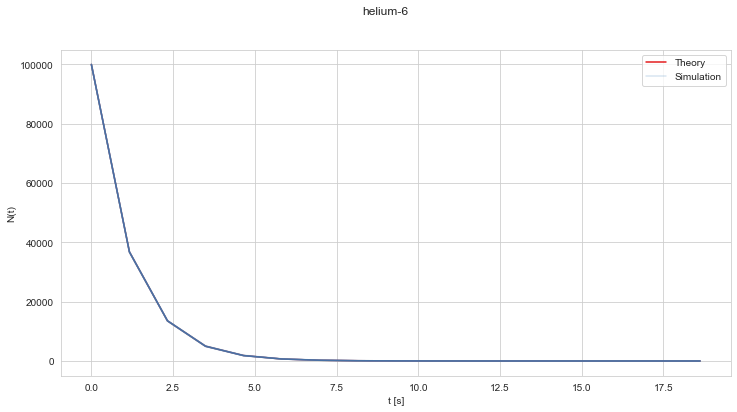

In [52]:
nuclide_compare_multiple(100000,'helium-6', nsims=10, a=.2)

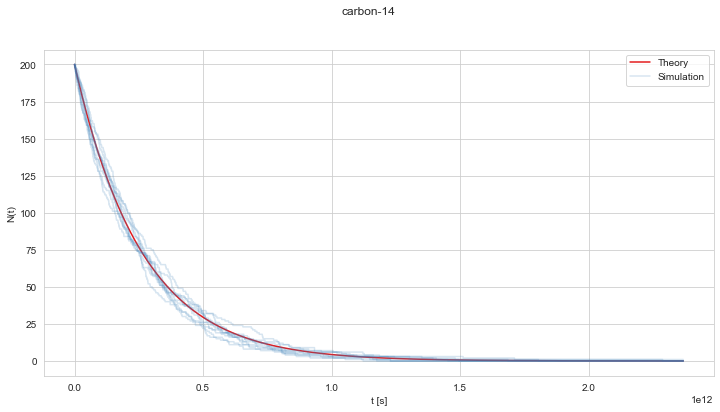

In [28]:
nuclide_compare_multiple(200,'carbon-14')

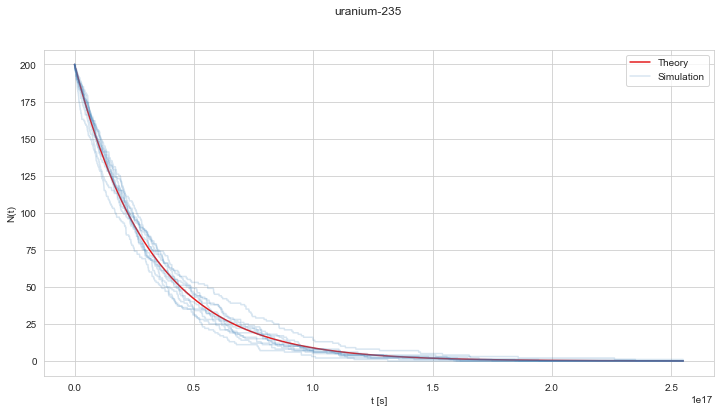

In [29]:
nuclide_compare_multiple(200,'uranium-235')

In [81]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc

def sim(n0, lamb, step):
    n = n0
    y = [n]
    keep = np.exp(-step * lamb)
    while n > 0:
        for i in range(n):
            if np.random.random() > keep:
                n -= 1
                if n == 0:
                    break
        y.append(n)
    return y

def decay(n0, lamb, step, length):
    n = n0
    y = [n]
    keep = np.exp(-step * lamb)
    for i in range(length - 1):
        n *= keep
        y.append(n)
    return y

app = dash.Dash(
    __name__, external_stylesheets=[dbc.themes.BOOTSTRAP]
)

controls = dbc.Card([
        dbc.FormGroup(
            [ 
                dbc.Label('Number of atoms'),
                html.Br(),
                dcc.Input(
                    id='n0',
                    type='number',
                    value=100
                )  
            ]
        ),
        html.Hr(style={"border" : ""}),
        dbc.FormGroup(
            [ 
                dbc.Label('Nuclides'),
                dcc.Dropdown(
                    id='t12',
                    options=[
                        {'label': 'helium-6', 'value': 806.7e-3},
                        {'label': 'carbon-14', 'value': 181e9},
                        {'label': 'uranium-235', 'value': 22.2e15}
                    ],
                    searchable=False
                )  
            ]
        ),
        html.Hr(style={"border" : ""}),
        dbc.FormGroup(
            [ 
                dbc.Label('Number of simulations'),
                html.Br(),
                dcc.Input(
                    id='nsims',
                    type='number',
                    value=10
                )            
            ]
        ),
        html.Hr(style={"border" : ""}),
        dbc.FormGroup(
            [ 
                dbc.Label('Alpha'),
                html.Br(),
                dcc.Input(
                    id='alpha',
                    type='number',
                    value=0.2
                )            
            ]
        )
    ],
    body=True)


app.layout = dbc.Container(
    [
        html.H2('Radioactive decay'),
        html.Hr(style={'border' : ''}),
        dbc.Row(
            [
                dbc.Col(controls, md=3),
                dbc.Col(dcc.Graph(id='graph'), md=9),
            ],
            align='left'
        )
    ],
    style={'max-width' : '90%', 'margin-top' : '2%'}
)


@app.callback(Output('graph', 'figure'), [
        Input('n0', 'value'),
        Input('t12', 'value'),
        Input('nsims', 'value'),
        Input('alpha', 'value')
    ])
def make_figure(n0, t12, nsims, alpha):
    #step = np.log2(n0)*t12/1e4
    step = np.power(n0,.8)/np.log(2)*t12/1e4    
    lamb = np.log(2)/t12
    sims = []
    for i in range(nsims):
        sims.append(sim(n0, lamb, step))
    y2 = decay(n0, lamb, step, max([len(s) for s in sims]))
    x = np.arange(0, step * (len(y2) - .5), step)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines',
                    name='theory',
                    line=dict(color='#e41a1c')))
    for s in sims:
        y = np.zeros(len(y2))
        y[:len(s)] = s    
        fig.add_trace(go.Scatter(x=x, y=y,
                    mode='lines',
                    name='simulation',
                    line=dict(color='#377eb8'),
                    opacity=alpha)) 
    fig.update_layout(
        xaxis_title='t [s]',
        yaxis_title='N(t)',
        showlegend=False,
        height=700,
        template='plotly_white'
    )
    return fig


In [ ]:
app.run_server()